In [105]:

import pandas as pd 
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np



df_train = pd.read_csv("../DATA/processed/synthetic_sales_expanded.csv")
df_train.head(2)

df_train['year'] = pd.to_datetime(df_train['DATE']).dt.year
df_train['month'] = pd.to_datetime(df_train['DATE']).dt.month
df_train['day'] = pd.to_datetime(df_train['DATE']).dt.day


df_train_less_500k = df_train[df_train['UNITARY_PRICE']<500]




In [106]:
df_train_less_500k

,PRODUTO,DATE,CLASSE TERAPÊUTICA,LABORATÓRIO,TARJA,PMC Sem Imposto,PMC 0%,PMC 12%,PMC 18%,PMC 21%,PMC 22%,UNITARY_PRICE,year,month,day
0,BAYCUTEN N,2023-01-01,D7B2 - CORTICOESTERÓIDES ASSOCIADOS A ANTIMICO...,BAYER S.A.,- (*),35.65,38.74,44.58,48.22,50.26,50.99,50.386250,2023,1,1
1,BAYCUTEN N,2023-01-02,D7B2 - CORTICOESTERÓIDES ASSOCIADOS A ANTIMICO...,BAYER S.A.,- (*),35.65,38.74,44.58,48.22,50.26,50.99,47.706926,2023,1,2
2,BAYCUTEN N,2023-01-03,D7B2 - CORTICOESTERÓIDES ASSOCIADOS A ANTIMICO...,BAYER S.A.,- (*),35.65,38.74,44.58,48.22,50.26,50.99,46.073566,2023,1,3
3,BAYCUTEN N,2023-01-04,D7B2 - CORTICOESTERÓIDES ASSOCIADOS A ANTIMICO...,BAYER S.A.,- (*),35.65,38.74,44.58,48.22,50.26,50.99,40.651228,2023,1,4
4,BAYCUTEN N,2023-01-05,D7B2 - CORTICOESTERÓIDES ASSOCIADOS A ANTIMICO...,BAYER S.A.,- (*),35.65,38.74,44.58,48.22,50.26,50.99,40.650933,2023,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15820297,VITER C + ZN,2024-12-27,A11G2 - ASSOCIAÇÕES COM VITAMINA C,NATULAB LABORATORIO S.A,- (*),27.51,29.90,34.41,37.21,38.79,39.36,31.966434,2024,12,27
15820298,VITER C + ZN,2024-12-28,A11G2 - ASSOCIAÇÕES COM VITAMINA C,NATULAB LABORATORIO S.A,- (*),27.51,29.90,34.41,37.21,38.79,39.36,31.261772,2024,12,28
15820299,VITER C + ZN,2024-12-29,A11G2 - ASSOCIAÇÕES COM VITAMINA C,NATULAB LABORATORIO S.A,- (*),27.51,29.90,34.41,37.21,38.79,39.36,37.899581,2024,12,29
15820300,VITER C + ZN,2024-12-30,A11G2 - ASSOCIAÇÕES COM VITAMINA C,NATULAB LABORATORIO S.A,- (*),27.51,29.90,34.41,37.21,38.79,39.36,38.525748,2024,12,30


KeyError: 'QUANTITY_SOLD'

In [108]:
# Generate a slope for each unique product in order of appearance

intercept = 40
error_std = 5
product_slopes = pd.Series(
    np.random.uniform(-1, 0.4, size = df_train_less_500k['PRODUTO'].nunique()),
    index=df_train_less_500k['PRODUTO'].unique()
)

# Generate noise for each product group (aligned with original DataFrame)
noise = df_train_less_500k.groupby('PRODUTO', sort=False)['PRODUTO'].transform(
    lambda x: np.random.normal(60, 25, len(x))
)

# Vectorized computation of QUANTITY_SOLD with non-negativity constraint
df_train_less_500k['QUANTITY_SOLD'] = np.maximum(
    0,  # Ensure quantity sold is at least 0
    np.round(  # Round to nearest integer
        intercept 
        + df_train_less_500k['PRODUTO'].map(product_slopes) * df_train_less_500k['UNITARY_PRICE'] 
        + noise
    )
)

/tmp/ipykernel_9488/2820616341.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_less_500k['QUANTITY_SOLD'] = np.maximum(


In [109]:
df_train_less_500k["REVENUE"] = df_train_less_500k["UNITARY_PRICE"] * df_train_less_500k["QUANTITY_SOLD"]
df_train_less_500k["PROFIT"] = (df_train_less_500k["UNITARY_PRICE"] - df_train_less_500k["PMC Sem Imposto"]) * df_train_less_500k["QUANTITY_SOLD"]
df_train_less_500k

/tmp/ipykernel_9488/215353605.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_less_500k["REVENUE"] = df_train_less_500k["UNITARY_PRICE"] * df_train_less_500k["QUANTITY_SOLD"]
/tmp/ipykernel_9488/215353605.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_less_500k["PROFIT"] = (df_train_less_500k["UNITARY_PRICE"] - df_train_less_500k["PMC Sem Imposto"]) * df_train_less_500k["QUANTITY_SOLD"]


,PRODUTO,DATE,CLASSE TERAPÊUTICA,LABORATÓRIO,TARJA,PMC Sem Imposto,PMC 0%,PMC 12%,PMC 18%,PMC 21%,PMC 22%,UNITARY_PRICE,year,month,day,QUANTITY_SOLD,REVENUE,PROFIT
0,BAYCUTEN N,2023-01-01,D7B2 - CORTICOESTERÓIDES ASSOCIADOS A ANTIMICO...,BAYER S.A.,- (*),35.65,38.74,44.58,48.22,50.26,50.99,50.386250,2023,1,1,108.0,5441.715027,1591.515027
1,BAYCUTEN N,2023-01-02,D7B2 - CORTICOESTERÓIDES ASSOCIADOS A ANTIMICO...,BAYER S.A.,- (*),35.65,38.74,44.58,48.22,50.26,50.99,47.706926,2023,1,2,128.0,6106.486501,1543.286501
2,BAYCUTEN N,2023-01-03,D7B2 - CORTICOESTERÓIDES ASSOCIADOS A ANTIMICO...,BAYER S.A.,- (*),35.65,38.74,44.58,48.22,50.26,50.99,46.073566,2023,1,3,142.0,6542.446433,1480.146433
3,BAYCUTEN N,2023-01-04,D7B2 - CORTICOESTERÓIDES ASSOCIADOS A ANTIMICO...,BAYER S.A.,- (*),35.65,38.74,44.58,48.22,50.26,50.99,40.651228,2023,1,4,100.0,4065.122835,500.122835
4,BAYCUTEN N,2023-01-05,D7B2 - CORTICOESTERÓIDES ASSOCIADOS A ANTIMICO...,BAYER S.A.,- (*),35.65,38.74,44.58,48.22,50.26,50.99,40.650933,2023,1,5,128.0,5203.319408,640.119408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15820297,VITER C + ZN,2024-12-27,A11G2 - ASSOCIAÇÕES COM VITAMINA C,NATULAB LABORATORIO S.A,- (*),27.51,29.90,34.41,37.21,38.79,39.36,31.966434,2024,12,27,90.0,2876.979062,401.079062
15820298,VITER C + ZN,2024-12-28,A11G2 - ASSOCIAÇÕES COM VITAMINA C,NATULAB LABORATORIO S.A,- (*),27.51,29.90,34.41,37.21,38.79,39.36,31.261772,2024,12,28,68.0,2125.800495,255.120495
15820299,VITER C + ZN,2024-12-29,A11G2 - ASSOCIAÇÕES COM VITAMINA C,NATULAB LABORATORIO S.A,- (*),27.51,29.90,34.41,37.21,38.79,39.36,37.899581,2024,12,29,112.0,4244.753056,1163.633056
15820300,VITER C + ZN,2024-12-30,A11G2 - ASSOCIAÇÕES COM VITAMINA C,NATULAB LABORATORIO S.A,- (*),27.51,29.90,34.41,37.21,38.79,39.36,38.525748,2024,12,30,110.0,4237.832277,1211.732277


In [110]:
df_train_less_500k_positive_sales = df_train_less_500k[df_train_less_500k['QUANTITY_SOLD']>0]

In [111]:
df_train_grouped = df_train_less_500k_positive_sales.groupby(["PRODUTO","PMC Sem Imposto","month","year","LABORATÓRIO", "CLASSE TERAPÊUTICA","TARJA"]).agg(
    UNITARY_PRICE_MEAN=("UNITARY_PRICE", "mean"),
    QUANTITY_SOLD_TOTAL=("QUANTITY_SOLD", "sum"),
    TOTAL_REVENUE=("REVENUE", "sum"),
    TOTAL_PROFIT = ("PROFIT", "sum")).reset_index()

df_train_grouped[df_train_grouped['PRODUTO'] == 'TOLREST']

,PRODUTO,PMC Sem Imposto,month,year,LABORATÓRIO,CLASSE TERAPÊUTICA,TARJA,UNITARY_PRICE_MEAN,QUANTITY_SOLD_TOTAL,TOTAL_REVENUE,TOTAL_PROFIT
351119,TOLREST,37.99,1,2023,ACHE LABORATORIOS FARMACEUTICOS SA,N6A4 - ANTIDEPRESSIVOS SSRI,Tarja Vermelha sob restrição,44.033405,1914.0,84028.727457,11315.867457
351120,TOLREST,37.99,1,2024,ACHE LABORATORIOS FARMACEUTICOS SA,N6A4 - ANTIDEPRESSIVOS SSRI,Tarja Vermelha sob restrição,43.192665,1871.0,79995.963655,8916.673655
351121,TOLREST,37.99,2,2023,ACHE LABORATORIOS FARMACEUTICOS SA,N6A4 - ANTIDEPRESSIVOS SSRI,Tarja Vermelha sob restrição,42.275142,1667.0,69962.547267,6633.217267
351122,TOLREST,37.99,2,2024,ACHE LABORATORIOS FARMACEUTICOS SA,N6A4 - ANTIDEPRESSIVOS SSRI,Tarja Vermelha sob restrição,43.136816,1765.0,76398.302808,9345.952808
351123,TOLREST,37.99,3,2023,ACHE LABORATORIOS FARMACEUTICOS SA,N6A4 - ANTIDEPRESSIVOS SSRI,Tarja Vermelha sob restrição,43.660535,2001.0,86877.380405,10859.390405
...,...,...,...,...,...,...,...,...,...,...,...
351284,TOLREST,161.52,10,2023,ACHE LABORATORIOS FARMACEUTICOS SA,N6A4 - ANTIDEPRESSIVOS SSRI,Tarja Vermelha sob restrição,174.860350,6.0,1049.162100,80.042100
351285,TOLREST,161.52,10,2024,ACHE LABORATORIOS FARMACEUTICOS SA,N6A4 - ANTIDEPRESSIVOS SSRI,Tarja Vermelha sob restrição,168.825373,18.0,3038.856713,131.496713
351286,TOLREST,161.52,11,2023,ACHE LABORATORIOS FARMACEUTICOS SA,N6A4 - ANTIDEPRESSIVOS SSRI,Tarja Vermelha sob restrição,176.143498,5.0,880.717488,73.117488
351287,TOLREST,161.52,12,2024,ACHE LABORATORIOS FARMACEUTICOS SA,N6A4 - ANTIDEPRESSIVOS SSRI,Tarja Vermelha sob restrição,189.677443,6.0,1138.064660,168.944660


In [120]:
df_train_grouped.sample(20)

,PRODUTO,PMC Sem Imposto,month,year,LABORATÓRIO,CLASSE TERAPÊUTICA,TARJA,UNITARY_PRICE_MEAN,QUANTITY_SOLD_TOTAL,TOTAL_REVENUE,TOTAL_PROFIT
55648,CALCITRAN B12,32.61,9,2024,FARMOQUIMICA S A,A12A - PRODUTOS A BASE DE CÁLCIO,Tarja Sem Tarja,40.565354,2166.0,8.818718e+04,17553.919040
90633,CLORIDRATO DE LOPERAMIDA,5.79,5,2023,SANDOZ DO BRASIL INDÚSTRIA FARMACÊUTICA LTDA,A7H - INIBIDORES DA MOTILIDADE,Tarja Vermelha,7.362945,3045.0,2.244352e+04,4812.973629
106894,CLOTRIMAZOL,10.45,3,2023,VITAMEDIC INDUSTRIA FARMACEUTICA LTDA,D1A1 - ANTIFÚNGICOS DERMATOLÓGICOS TÓPICOS,Tarja Sem Tarja,13.133839,3150.0,4.152503e+04,8607.530524
5721,ACTIFEDRIN,11.87,12,2024,FARMOQUIMICA S A,R1B - PREPARAÇÕES SISTÊMICAS NASAIS,Tarja Vermelha,14.646773,2811.0,4.100628e+04,7639.708677
225868,LOZEPREL,26.89,12,2024,MULTILAB INDUSTRIA E COMERCIO DE PRODUTOS FARM...,A2B2 - INIBIDORES DA BOMBA DE PRÓTONS,Tarja Vermelha,30.944728,3051.0,9.393713e+04,11895.740347
55809,CALMASYN,54.06,2,2024,CIFARMA CIENTÍFICA FARMACÊUTICA LTDA,N5B5 - HIPNÓTICOS E SEDATIVOS HERBÁCEOS,Tarja Sem Tarja,69.595927,1698.0,1.172702e+05,25476.355393
116821,DECOLE,92.01,5,2023,MYRALIS INDUSTRIA FARMACEUTICA LTDA,A11C2 - VITAMINA D PURA,Tarja Vermelha,115.839442,3933.0,4.584437e+05,96568.348632
121300,DESIRÉE,236.84,9,2023,FARMOQUIMICA S A,N7D9 - TODOS OS OUTROS PRODUTOS ANTIALZHEIMER,Tarja Vermelha sob restrição,264.452561,3833.0,1.012963e+06,105155.268014
311747,RETEMIC,33.30,1,2023,APSEN FARMACEUTICA S/A,G4D4 - PRODUTOS PARA INCONTINÊNCIA URINÁRIA,Tarja Vermelha,41.976254,1925.0,8.059630e+04,16493.799829
232914,MEBENDAZOL,287.99,4,2024,GREENPHARMA QUÍMICA E FARMACÊUTICA LTDA,P1B - ANTI-HELMÍNTICOS EXCETO ESQUISTOSSOMICID...,- (*),332.778040,383.0,1.254079e+05,15107.713565


/tmp/ipykernel_9488/2982889803.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_product['PREDICTED_SALES'] = model.predict(sm.add_constant(df_product['UNITARY_PRICE_MEAN']))


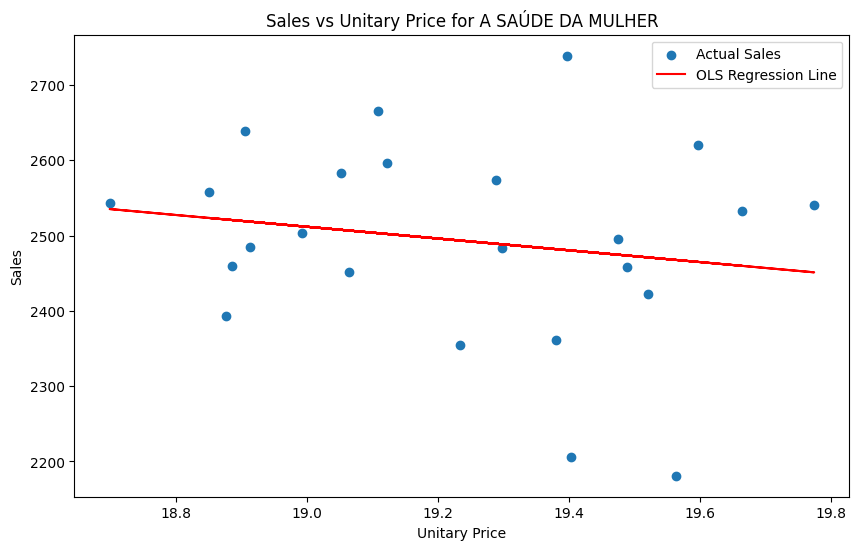

In [126]:
#Choose one product, for example, 'BAYCUTEN N'

product_name = 'A SAÚDE DA MULHER'
df_product = df_train_grouped[df_train_grouped['PRODUTO'] == product_name]

# Fit an OLS model
model = sm.OLS(df_product['QUANTITY_SOLD_TOTAL'], sm.add_constant(df_product['UNITARY_PRICE_MEAN'])).fit()

# Predict the values
df_product['PREDICTED_SALES'] = model.predict(sm.add_constant(df_product['UNITARY_PRICE_MEAN']))

# Plot the scatterplot with the regression line
plt.figure(figsize=(10, 6))
plt.scatter(df_product['UNITARY_PRICE_MEAN'], df_product['QUANTITY_SOLD_TOTAL'], label='Actual Sales')
plt.plot(df_product['UNITARY_PRICE_MEAN'], df_product['PREDICTED_SALES'], color='red', label='OLS Regression Line')
plt.xlabel('Unitary Price')
plt.ylabel('Sales')
plt.title(f'Sales vs Unitary Price for {product_name}')
plt.legend()
plt.show()

                             OLS Regression Results                            
Dep. Variable:     QUANTITY_SOLD_TOTAL   R-squared:                       0.002
Model:                             OLS   Adj. R-squared:                  0.001
Method:                  Least Squares   F-statistic:                     3.703
Date:                 Thu, 30 Jan 2025   Prob (F-statistic):             0.0544
Time:                         09:59:54   Log-Likelihood:                -19687.
No. Observations:                 2256   AIC:                         3.938e+04
Df Residuals:                     2254   BIC:                         3.939e+04
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               3524.4

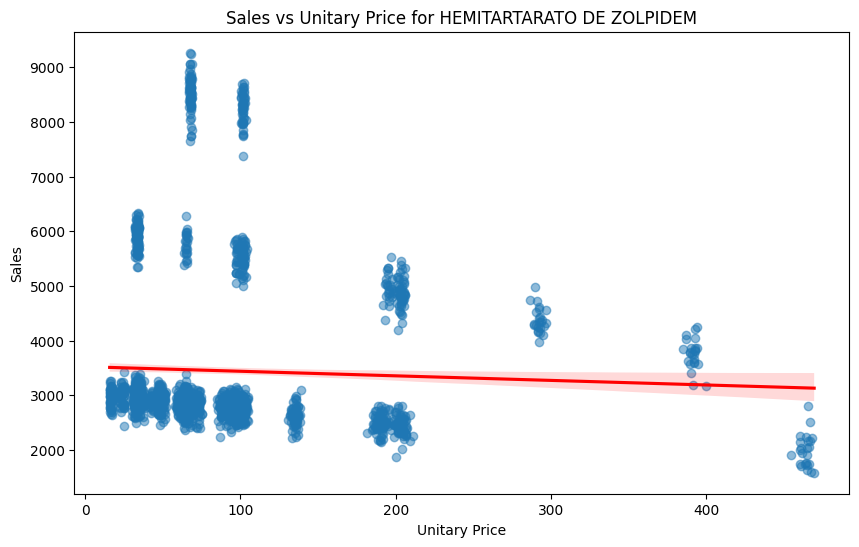

In [90]:
import seaborn as sns
product_name = 'HEMITARTARATO DE ZOLPIDEM'
df_product = df_train_grouped[df_train_grouped['PRODUTO'] == product_name]

# Check if data exists
if df_product.empty:
    raise ValueError(f"No data found for product: {product_name}")

# Fit OLS model
X = sm.add_constant(df_product['UNITARY_PRICE_MEAN'])
model = sm.OLS(df_product['QUANTITY_SOLD_TOTAL'], X).fit()

# Print model diagnostics
print(model.summary())

# Plot
plt.figure(figsize=(10, 6))
sns.regplot(
    x=df_product['UNITARY_PRICE_MEAN'],
    y=df_product['QUANTITY_SOLD_TOTAL'],
    scatter_kws={'alpha': 0.5},
    line_kws={'color': 'red'}
)
plt.title(f'Sales vs Unitary Price for {product_name}')
plt.xlabel('Unitary Price')
plt.ylabel('Sales')
plt.show()

/tmp/ipykernel_9488/3676491951.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_year['PREDICTED_SALES'] = model.predict(X)
/tmp/ipykernel_9488/3676491951.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_year['PREDICTED_SALES'] = model.predict(X)


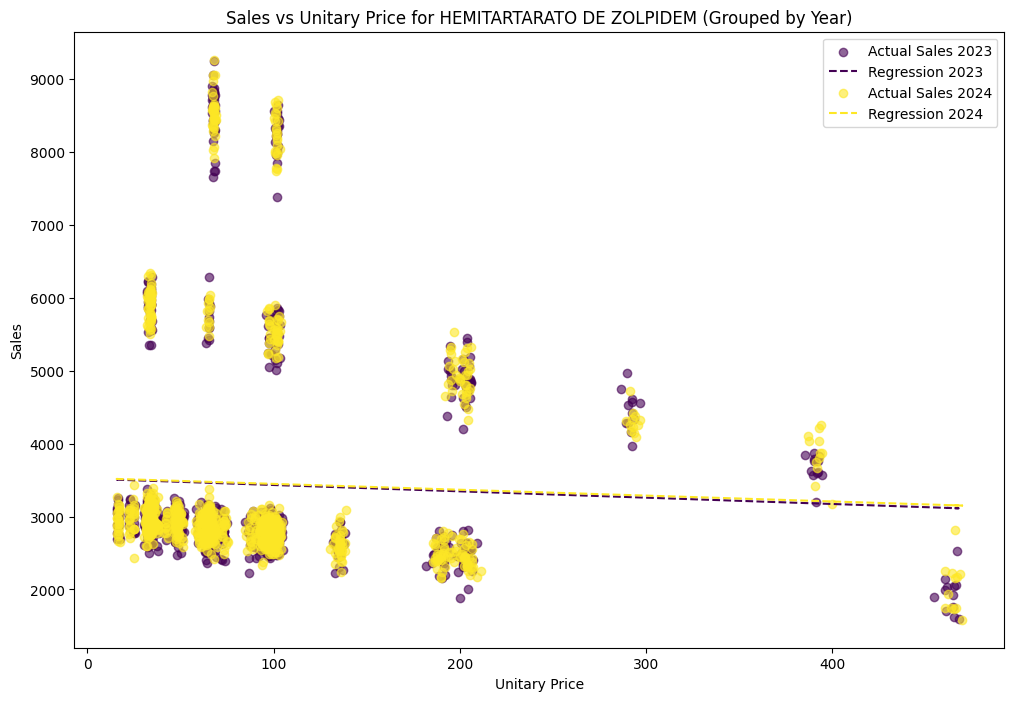


Year 2023 Regression Summary:
                             OLS Regression Results                            
Dep. Variable:     QUANTITY_SOLD_TOTAL   R-squared:                       0.002
Model:                             OLS   Adj. R-squared:                  0.001
Method:                  Least Squares   F-statistic:                     1.988
Date:                 Thu, 30 Jan 2025   Prob (F-statistic):              0.159
Time:                         10:00:04   Log-Likelihood:                -9843.5
No. Observations:                 1128   AIC:                         1.969e+04
Df Residuals:                     1126   BIC:                         1.970e+04
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Assuming your data has a 'YEAR' column. If not, create it from a date column:
# df_train_grouped['YEAR'] = pd.to_datetime(df_train_grouped['DATE']).dt.year

product_name = 'HEMITARTARATO DE ZOLPIDEM'
df_product = df_train_grouped[df_train_grouped['PRODUTO'] == product_name]

# Check if data exists
if df_product.empty:
    raise ValueError(f"No data found for product: {product_name}")

# Create a figure
plt.figure(figsize=(12, 8))

# Define colors for different years (using a colormap)
years = df_product['year'].unique()
colors = plt.cm.viridis(np.linspace(0, 1, len(years)))  # Use a colormap like viridis, rainbow, etc.

# Loop through each year and fit/predict/plot
for idx, year in enumerate(years):
    # Filter data for the year
    df_year = df_product[df_product['year'] == year]
    
    # Fit OLS model
    X = sm.add_constant(df_year['UNITARY_PRICE_MEAN'])
    model = sm.OLS(df_year['QUANTITY_SOLD_TOTAL'], X).fit()
    
    # Predict values
    df_year['PREDICTED_SALES'] = model.predict(X)
    
    # Plot scatter points
    plt.scatter(
        df_year['UNITARY_PRICE_MEAN'],
        df_year['QUANTITY_SOLD_TOTAL'],
        color=colors[idx],
        alpha=0.6,
        label=f'Actual Sales {year}'
    )
    
    # Plot regression line
    plt.plot(
        df_year['UNITARY_PRICE_MEAN'],
        df_year['PREDICTED_SALES'],
        color=colors[idx],
        linestyle='--',
        label=f'Regression {year}'
    )

# Add labels and legend
plt.xlabel('Unitary Price')
plt.ylabel('Sales')
plt.title(f'Sales vs Unitary Price for {product_name} (Grouped by Year)')
plt.legend()
plt.show()

# Optional: Print model summaries
for year in years:
    df_year = df_product[df_product['year'] == year]
    X = sm.add_constant(df_year['UNITARY_PRICE_MEAN'])
    model = sm.OLS(df_year['QUANTITY_SOLD_TOTAL'], X).fit()
    print(f"\nYear {year} Regression Summary:")
    print(model.summary())

/tmp/ipykernel_9488/537105384.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_year['PREDICTED_SALES'] = model.predict(X)
/tmp/ipykernel_9488/537105384.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_year['PREDICTED_SALES'] = model.predict(X)


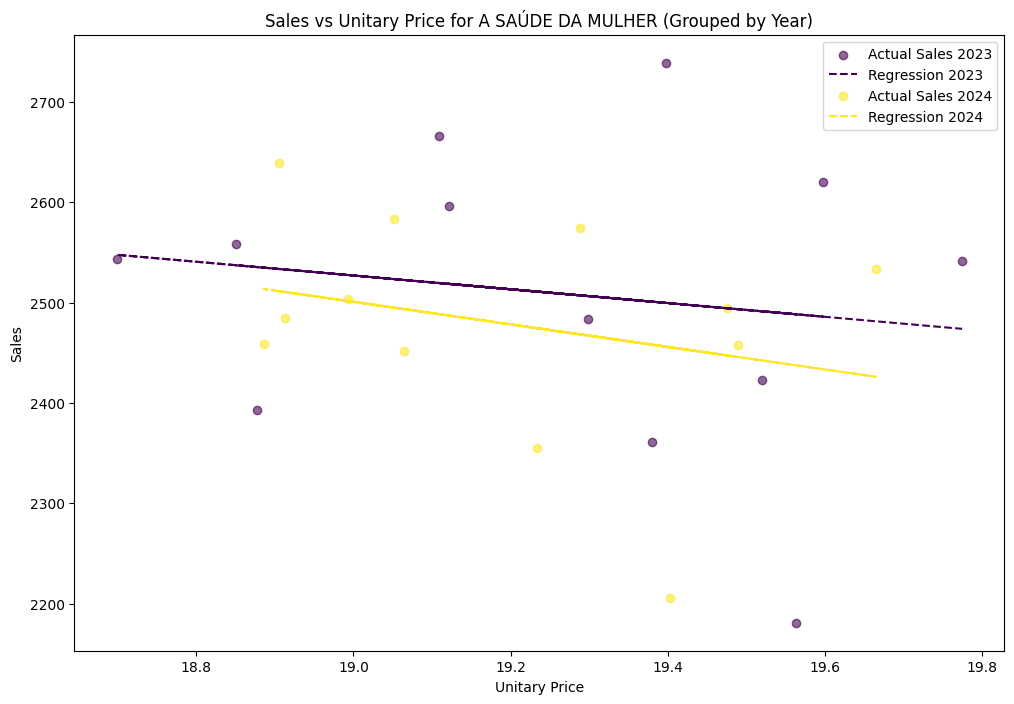

/tmp/ipykernel_9488/537105384.py:58: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_sales = model.params[0] + model.params[1] * price_range
/tmp/ipykernel_9488/537105384.py:58: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_sales = model.params[0] + model.params[1] * price_range


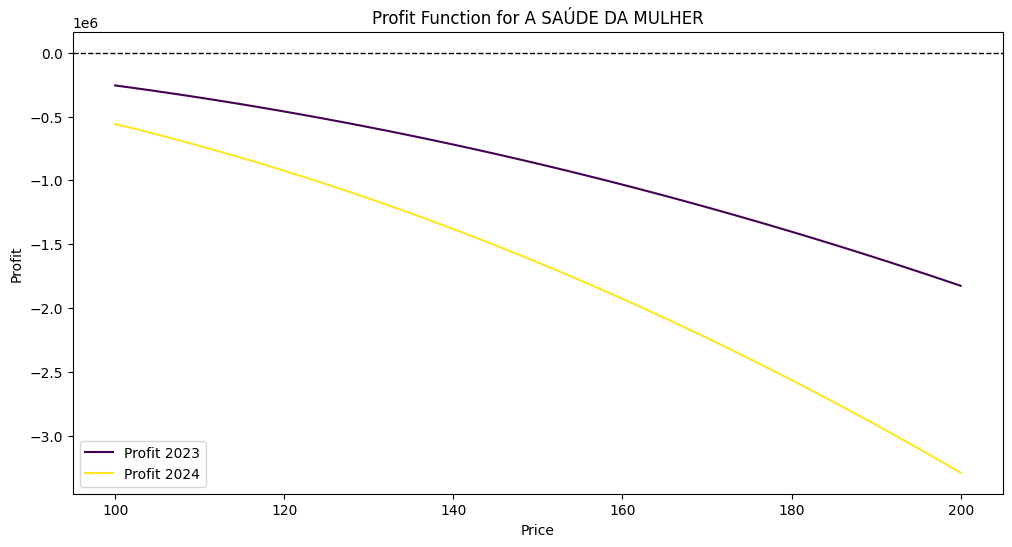

In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

product_name = 'A SAÚDE DA MULHER'
df_product = df_train_grouped[df_train_grouped['PRODUTO'] == product_name]

if df_product.empty:
    raise ValueError(f"No data found for product: {product_name}")

plt.figure(figsize=(12, 8))

years = df_product['year'].unique()
colors = plt.cm.viridis(np.linspace(0, 1, len(years)))

for idx, year in enumerate(years):
    df_year = df_product[df_product['year'] == year]
    
    X = sm.add_constant(df_year['UNITARY_PRICE_MEAN'])
    model = sm.OLS(df_year['QUANTITY_SOLD_TOTAL'], X).fit()
    
    df_year['PREDICTED_SALES'] = model.predict(X)
    
    plt.scatter(
        df_year['UNITARY_PRICE_MEAN'],
        df_year['QUANTITY_SOLD_TOTAL'],
        color=colors[idx],
        alpha=0.6,
        label=f'Actual Sales {year}'
    )
    
    plt.plot(
        df_year['UNITARY_PRICE_MEAN'],
        df_year['PREDICTED_SALES'],
        color=colors[idx],
        linestyle='--',
        label=f'Regression {year}'
    )

plt.xlabel('Unitary Price')
plt.ylabel('Sales')
plt.title(f'Sales vs Unitary Price for {product_name} (Grouped by Year)')
plt.legend()
plt.show()

# Profit Function Plot
plt.figure(figsize=(12, 6))
price_range = np.linspace(100, 200, 100)

for idx, year in enumerate(years):
    df_year = df_product[df_product['year'] == year]
    
    X = sm.add_constant(df_year['UNITARY_PRICE_MEAN'])
    model = sm.OLS(df_year['QUANTITY_SOLD_TOTAL'], X).fit()
    
    predicted_sales = model.params[0] + model.params[1] * price_range
    profit = (price_range - df_year['PMC Sem Imposto'].mean()) * predicted_sales
    
    plt.plot(price_range, profit, color=colors[idx], label=f'Profit {year}')

plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.xlabel('Price')
plt.ylabel('Profit')
plt.title(f'Profit Function for {product_name}')
plt.legend()
plt.show()


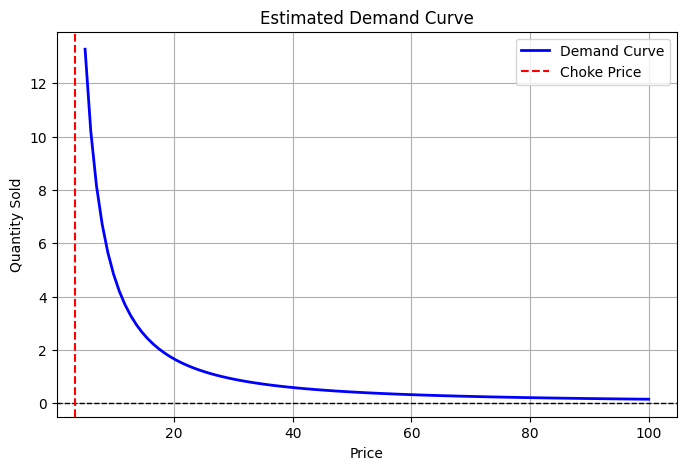

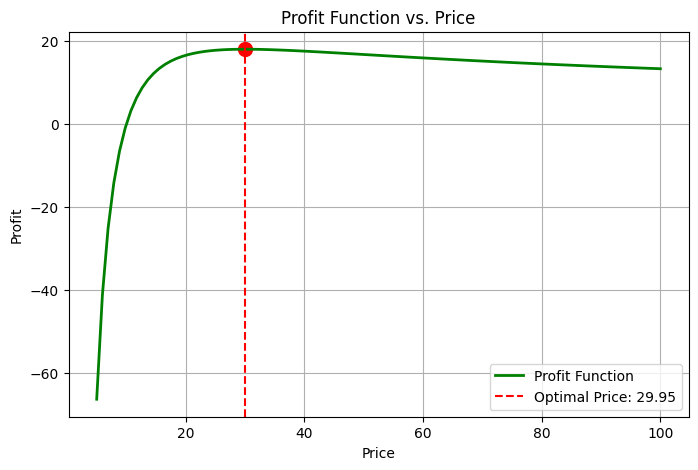

In [164]:
import matplotlib.pyplot as plt
import numpy as np

# Simulated elasticity and intercept (from a model fit)
alpha = 5   # Intercept (log scale)
beta = -1.5 # Elasticity (negative slope)

# Generate price range
prices = np.linspace(5, 100, 100)  # Price range from 5 to 100

# Compute estimated demand
demand = np.exp(alpha + beta * np.log(prices))

# Plot the demand curve
plt.figure(figsize=(8, 5))
plt.plot(prices, demand, label="Demand Curve", color="blue", linewidth=2)

# Labels and title
plt.xlabel("Price")
plt.ylabel("Quantity Sold")
plt.title("Estimated Demand Curve")
plt.axhline(0, color='black', linestyle='--', linewidth=1)  # Zero demand line
plt.axvline(-alpha/beta, color='red', linestyle='--', label="Choke Price")  # When Q = 0
plt.legend()
plt.grid()

# Show the plot
plt.show()
import matplotlib.pyplot as plt
import numpy as np

# Simulated parameters (from an estimated model)
alpha = 5    # Intercept (log scale)
beta = -1.0  # Price elasticity
MC = 10      # Assumed marginal cost

# Generate a range of prices
prices = np.linspace(5, 100, 100)  # Price range from 5 to 100

# Compute demand function Q(P)
demand = np.exp(alpha + beta * np.log(prices))

# Compute profit function: Profit(P) = (P - MC) * Q(P)
profit = (prices - MC) * demand

# Find the optimal price where profit is maximized
optimal_price = prices[np.argmax(profit)]
max_profit = max(profit)

# Plot the profit function
plt.figure(figsize=(8, 5))
plt.plot(prices, profit, label="Profit Function", color="green", linewidth=2)

# Mark the optimal price
plt.axvline(optimal_price, color="red", linestyle="--", label=f"Optimal Price: {optimal_price:.2f}")
plt.scatter(optimal_price, max_profit, color="red", s=100)

# Labels and title
plt.xlabel("Price")
plt.ylabel("Profit")
plt.title("Profit Function vs. Price")
plt.legend()
plt.grid()

# Show the plot
plt.show()


In [75]:
df_train_grouped

,PRODUTO,PMC Sem Imposto,month,year,LABORATÓRIO,CLASSE TERAPÊUTICA,TARJA,UNITARY_PRICE_MEAN,QUANTITY_SOLD_TOTAL,TOTAL_REVENUE,TOTAL_PROFIT
0,A SAÚDE DA MULHER,15.31,1,2023,EMS S/A,G2X1 - ANTIESPASMÓDICOS GINECOLÓGICOS,- (*),19.520317,2481.0,48714.549743,10546.719743
1,A SAÚDE DA MULHER,15.31,1,2024,EMS S/A,G2X1 - ANTIESPASMÓDICOS GINECOLÓGICOS,- (*),18.993252,2393.0,50102.000687,9652.980687
2,A SAÚDE DA MULHER,15.31,2,2023,EMS S/A,G2X1 - ANTIESPASMÓDICOS GINECOLÓGICOS,- (*),19.563846,2248.0,44867.822723,9471.102723
3,A SAÚDE DA MULHER,15.31,2,2024,EMS S/A,G2X1 - ANTIESPASMÓDICOS GINECOLÓGICOS,- (*),19.402758,2278.0,45745.420570,9476.030570
4,A SAÚDE DA MULHER,15.31,3,2023,EMS S/A,G2X1 - ANTIESPASMÓDICOS GINECOLÓGICOS,- (*),18.876765,2548.0,47637.970660,8842.430660
...,...,...,...,...,...,...,...,...,...,...,...
348434,ÉSIO,264.90,10,2024,EUROFARMA LABORATORIOS S.A.,A2B2 - INIBIDORES DA BOMBA DE PRÓTONS,Tarja Vermelha,291.519347,352.0,0.000000,0.000000
348435,ÉSIO,264.90,11,2023,EUROFARMA LABORATORIOS S.A.,A2B2 - INIBIDORES DA BOMBA DE PRÓTONS,Tarja Vermelha,298.414340,233.0,0.000000,0.000000
348436,ÉSIO,264.90,11,2024,EUROFARMA LABORATORIOS S.A.,A2B2 - INIBIDORES DA BOMBA DE PRÓTONS,Tarja Vermelha,301.232824,247.0,0.000000,0.000000
348437,ÉSIO,264.90,12,2023,EUROFARMA LABORATORIOS S.A.,A2B2 - INIBIDORES DA BOMBA DE PRÓTONS,Tarja Vermelha,287.983715,299.0,0.000000,0.000000


In [ ]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np

def run_lmm_and_optimize(df):
    results = []
    products = df["PRODUTO"].unique()
    
    for product in products:
        df_product = df[df["PRODUTO"] == product]
        if len(df_product) < 10:  # Require sufficient data points
            print(f"Skipping {product}: insufficient data.")
            continue
        
        # Ensure columns exist and are correctly named
        required_columns = ['UNITARY_PRICE_MEAN', 'year', 'month', 'LABORATÓRIO', 'TARJA', 'PMC Sem Imposto']
        for col in required_columns:
            if col not in df_product.columns:
                raise KeyError(f"Column '{col}' not found in the DataFrame.")
        
        # Define the LMM formula (fixed effects only)
        formula = "QUANTITY_SOLD_TOTAL ~ UNITARY_PRICE_MEAN + C(year) + C(month)"
        
        # Fit the model with a single random effect (e.g., LABORATÓRIO)
        try:
            model = smf.mixedlm(
                formula,
                data=df_product,
                groups=df_product["LABORATÓRIO"],  # Single grouping variable
                re_formula="~1"  # Random intercept for LABORATÓRIO
            )
            result = model.fit(reml=False)
        except Exception as e:
            print(f"Failed for {product}: {str(e)}")
            continue
        
        # Extract fixed effect coefficients
        if "UNITARY_PRICE_MEAN" not in result.fe_params:
            print(f"Skipping {product}: Price coefficient not found.")
            continue
        beta_price = result.fe_params["UNITARY_PRICE_MEAN"]
        
        # Calculate price elasticity
        mean_price = df_product["UNITARY_PRICE_MEAN"].mean()
        mean_quantity = df_product["QUANTITY_SOLD_TOTAL"].mean()
        elasticity = beta_price * (mean_price / mean_quantity)
        
        # Calculate optimal price
        PMC = df_product["PMC Sem Imposto"].mean()
        optimal_price = (result.fe_params["Intercept"] + beta_price * PMC) / (2 * beta_price)
        
        # Store results
        results.append({
            "PRODUTO": product,
            "ELASTICITY": elasticity,
            "OPTIMAL_PRICE": optimal_price,
            "CURRENT_PRICE": mean_price,
            "BETA_PRICE": beta_price,
            #"R2": result.rsquared
        })
    
    return pd.DataFrame(results)

# Run the analysis
results_df = run_lmm_and_optimize(df_train_grouped)
print(results_df)

In [78]:
results_df

,PRODUTO,ELASTICITY,OPTIMAL_PRICE,CURRENT_PRICE,BETA_PRICE
0,A SAÚDE DA MULHER,-0.917488,-12.443307,19.231606,-117.171164
1,AAS,-0.959359,29.073826,70.491987,-19.680596
2,AAS PROTECT,-0.827707,-15.476363,21.499311,-87.311464
3,ABC,-0.408422,-38.864138,28.480199,-31.186246
4,ABCLER ABNAT,-6.939118,-22.567130,130.658558,-29.844929
...,...,...,...,...,...
3984,ÁRIA,-1.067939,-29.194368,54.231600,-104.937514
3985,ÁRTICO,1.224320,29.595391,77.200091,16.975788
3986,ÁRTICO CAPS,-0.754974,65.178000,146.972928,-16.024615
3987,ÉGIDE,-0.800095,-48.299710,69.728177,-19.031880
